## Первое домашне задание будет состоять из двух частей.

**Часть 1.**

- Обучить модель, ктоторая предсказывает параметры для смеси гауссиан.


**Часть 2.**

$$ \mathcal{N} = \frac{1}{\sigma\sqrt{2\pi}}\exp\left\{-\frac{(x - \mu)^2}{2\sigma^2}\right\} $$

- Вывести и выписать значение энтропии для нормального распределения $H[P]= -\sum_{x\in\mathcal{X}}p(x) \log p(x)$

- Выписать KL дивергенцию между двумя нормальныи распределениями.

$ KL = \sum_{i=1}^{N} p(x_i) \cdot \log \frac{ p(x_i)}{q(x_i)} $, где $p$ и $q$ нормальные распределения с разными средними и дисперсиями. Фианльное решение должно быть функцией от $\mu_1$,$\mu_1$,$\sigma_1$,$\sigma_2$.


### Как сдать задания


**Для части один** напишите код, запустите его и нарисуйте графики, которые демонстрируют что если семплировать из параметров, полученных после обучения мы получим распределение похожее на оригинальное.

**Для части два** вставьте в ноутбук избражение с решением или введите его в латех в ноутбуке.


## Заготовка кода для задания 2

Данный код это только пример, это не обязательно правильое решение, можно использовать любую другую модель.

Модель на вход получает данные, а на выходе возвращает параметры для двух нормальных распределений и как и параметр смешивания. И того 5 параметров.

Проверка кода будет осуществляется путем его запуска и отрисовки графиков.


In [1]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

RANDOM_SEED = 3
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED) 

In [2]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED) 


def gen_data(mu_1=0, sigma_1=1, mu_2=0, sigma_2=1, proportion=0.3, n=1000):
    data = np.zeros(n)
    for i in range(n):
        if np.random.rand() < proportion:
            data[i] = np.random.normal(loc=mu_1, scale=sigma_1)
        else:
            data[i] = np.random.normal(loc=mu_2, scale=sigma_2)
    return data

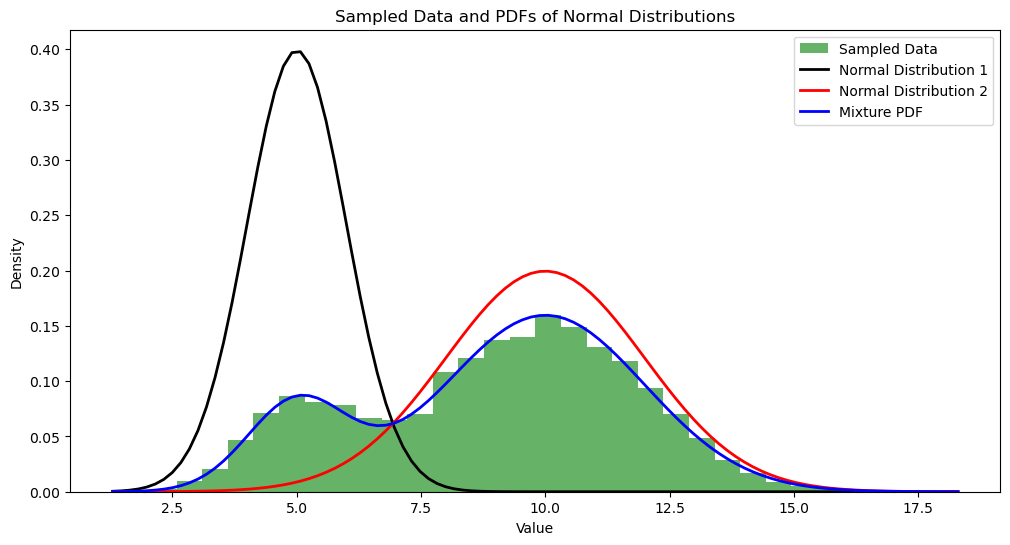

In [3]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED) 


#Parameters for the normal distributions
mu_1 = 5
sigma_1 = 1
mu_2 = 10
sigma_2 = 2
proportion = 0.2
n = 10000

# Generate data
data = gen_data(mu_1, sigma_1, mu_2, sigma_2, proportion, n)

# Plot the sampled data
plt.figure(figsize=(12, 6))

# Histogram of the sampled data
plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Sampled Data')

# Plot the PDFs of the two normal distributions
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p1 = stats.norm.pdf(x, mu_1, sigma_1)
p2 = stats.norm.pdf(x, mu_2, sigma_2)
plt.plot(x, p1, 'k', linewidth=2, label='Normal Distribution 1')
plt.plot(x, p2, 'r', linewidth=2, label='Normal Distribution 2')

# Plot the mixture PDF
mixture_pdf = proportion * p1 + (1 - proportion) * p2
plt.plot(x, mixture_pdf, 'b', linewidth=2, label='Mixture PDF')

# Add labels and legend
plt.title('Sampled Data and PDFs of Normal Distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

### Комментарии
Зафиксируем seed, чтобы результат был реплицируемым. На каждой эпохе будем проходиться по всей выборке. Proportion будем предсказывать не в чистом виде (число от 0 до 1), а в виде параметра сигмоиды (см функцию forward). Ответ модели, соответственно, необходимо будет преобразовывать torch.sigmoid(model.proportion).item().

In [4]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED) 


class MixtureModel(nn.Module):
    def __init__(self):
        super(MixtureModel, self).__init__()
        self.mu_1 = nn.Parameter(torch.tensor(0.0))
        self.sigma_1 = nn.Parameter(torch.tensor(1.0))
        self.mu_2 = nn.Parameter(torch.tensor(0.0))
        self.sigma_2 = nn.Parameter(torch.tensor(1.0))
        self.proportion = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        p1 = torch.exp(-(x - self.mu_1)**2 / (2 * self.sigma_1**2)) / (self.sigma_1 * torch.sqrt(2 * torch.tensor(np.pi)))
        p2 = torch.exp(-(x - self.mu_2)**2 / (2 * self.sigma_2**2)) / (self.sigma_2 * torch.sqrt(2 * torch.tensor(np.pi)))
        mixture_pdf = torch.sigmoid(self.proportion) * p1 + (1 - torch.sigmoid(self.proportion)) * p2
        return mixture_pdf

    
# Convert data to PyTorch tensor
data_tensor = torch.tensor(data, dtype=torch.float32)

# Initialize the model, loss function, and optimizer
model = MixtureModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10000
batch_size = 1000
n_batches = data_tensor.size(0) // batch_size
perm_indices = torch.randperm(data_tensor.size(0), generator=torch.Generator().manual_seed(RANDOM_SEED))
for epoch in range(num_epochs):
    for n_batch in range(n_batches):
        # Forward pass
        indices = perm_indices[n_batch*batch_size:(n_batch+1)*batch_size] 
        outputs = model.forward(data_tensor[indices])
        loss = -torch.log(outputs.clip(1e-30)).mean()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, mu_1: {model.mu_1.item():.4f}, sigma_1: {model.sigma_1.item():.4f}, mu_2: {model.mu_2.item():.4f}, sigma_2: {model.sigma_2.item():.4f}, prop: {torch.sigmoid(model.proportion).item():.4f}')

# Print the estimated parameters
print(f'Estimated mu_1: {model.mu_1.item():.4f}')
print(f'Estimated sigma_1: {model.sigma_1.item():.4f}')
print(f'Estimated mu_2: {model.mu_2.item():.4f}')
print(f'Estimated sigma_2: {model.sigma_2.item():.4f}')
print(f'Estimated proportion: {torch.sigmoid(model.proportion).item():.4f}')

Epoch [1000/10000], Loss: 2.7053, mu_1: 0.2721, sigma_1: 1.2377, mu_2: 6.7529, sigma_2: 3.8695, prop: 0.0036
Epoch [2000/10000], Loss: 2.4179, mu_1: 0.7488, sigma_1: 1.3295, mu_2: 8.9632, sigma_2: 2.7378, prop: 0.0001
Epoch [3000/10000], Loss: 2.4181, mu_1: 4.1629, sigma_1: -0.0590, mu_2: 8.9631, sigma_2: 2.7380, prop: 0.0001
Epoch [4000/10000], Loss: 2.4179, mu_1: 4.3002, sigma_1: -0.0193, mu_2: 8.9632, sigma_2: 2.7379, prop: 0.0000
Epoch [5000/10000], Loss: 2.4179, mu_1: 4.4278, sigma_1: -0.0368, mu_2: 8.9631, sigma_2: 2.7379, prop: 0.0000
Epoch [6000/10000], Loss: 2.4179, mu_1: 4.4805, sigma_1: -0.0264, mu_2: 8.9632, sigma_2: 2.7379, prop: 0.0000
Epoch [7000/10000], Loss: 2.4179, mu_1: 4.4520, sigma_1: 0.0427, mu_2: 8.9632, sigma_2: 2.7379, prop: 0.0000
Epoch [8000/10000], Loss: 2.4166, mu_1: 4.4119, sigma_1: 0.0097, mu_2: 8.9673, sigma_2: 2.7356, prop: 0.0006
Epoch [9000/10000], Loss: 2.3620, mu_1: 5.0128, sigma_1: 1.0013, mu_2: 9.9844, sigma_2: 2.0242, prop: 0.2054
Epoch [10000/10

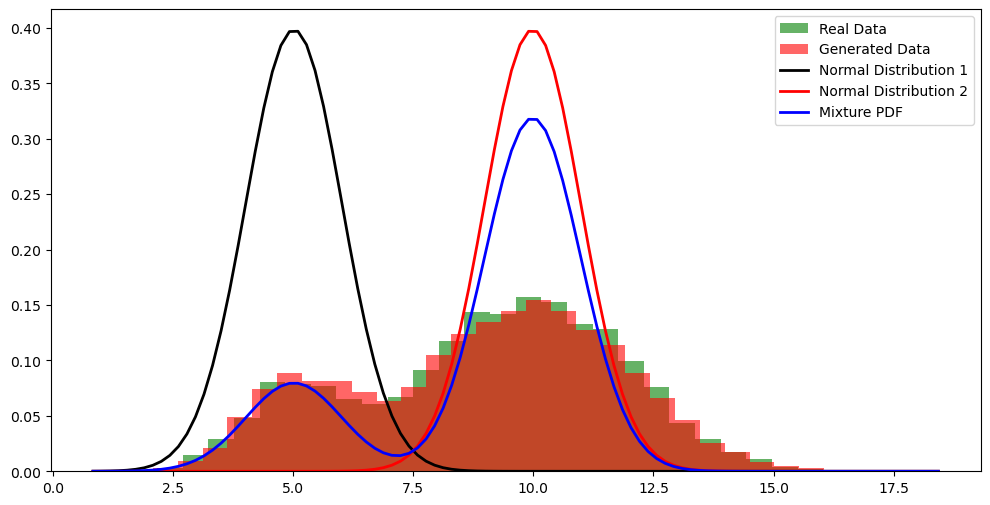

In [5]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


# Generate data
data_gen = gen_data(model.mu_1.item(), model.sigma_1.item(), model.mu_2.item(), model.sigma_2.item(), torch.sigmoid(model.proportion).item(), n)

data = gen_data(mu_1, sigma_1, mu_2, sigma_2, proportion, n)

# Plot the sampled data
plt.figure(figsize=(12, 6))

# Histogram of the sampled data
plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Real Data')

plt.hist(data_gen, bins=30, density=True, alpha=0.6, color='r', label='Generated Data')

# Plot the PDFs of the two normal distributions
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p1 = stats.norm.pdf(x, model.mu_1.item(), model.sigma_1.item())
p2 = stats.norm.pdf(x, model.mu_2.item(), model.sigma_1.item())
plt.plot(x, p1, 'k', linewidth=2, label='Normal Distribution 1')
plt.plot(x, p2, 'r', linewidth=2, label='Normal Distribution 2')

# Plot the mixture PDF
mixture_pdf = proportion * p1 + (1 - proportion) * p2
plt.plot(x, mixture_pdf, 'b', linewidth=2, label='Mixture PDF')
plt.legend()

### Ваша задача с помощью модели найти параметры распределения максмиально близкие к оригинальным.

# Энтропия нормального распределения 
Энтропия непрерывного распределения P с плотностью p определяется через интеграл:
\begin{equation}
H(P) = -\int_{-\infty}^{+\infty} p(x)\cdot \log\left(p(x)\right) dx
\end{equation}
Тогда для нормального распределения с плотностью $p(x) = \frac{1}{\sigma\sqrt{2\pi}}\exp{\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)}$ энтропия:
$$
H(P) = -\frac{1}{\sigma\sqrt{2\pi}}\int_{-\infty}^{+\infty}\exp{\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)} \log\left(\frac{1}{\sigma\sqrt{2\pi}}\exp{\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)}\right)dx =\\
= \frac{1}{\sigma\sqrt{2\pi}} 
\int_{-\infty}^{+\infty}
\exp{ \left( -\frac{(x-\mu)^2}{2\sigma^2}\right) } 
\left( \log{\left(\sigma\sqrt{2\pi}\right)} + \frac{(x-\mu)^2}{2\sigma^2}\right) dx =
$$
$$
= \log{\left(\sigma\sqrt{2\pi}\right)} + \frac{2}{\sigma\sqrt{2\pi}} 
\int_{\mu}^{+\infty}
\exp{ \left( -\frac{(x-\mu)^2}{2\sigma^2}\right) } \frac{(x-\mu)^2}{2\sigma^2} dx =
$$
$$
= \log{\left(\sigma\sqrt{2\pi}\right)} + \frac{1}{\sqrt{2\pi}} 
\int_{0}^{+\infty} \sqrt{2t}
\exp{ \left(-t\right)} dt = 
$$
$$
= \log{\left(\sigma\sqrt{2\pi}\right)} + \frac{1}{2}
$$
В вычислениях использовали свойство плотности $ \frac{1}{\sigma\sqrt{2\pi}}\int_{-\infty}^{+\infty}\exp{\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)}  = 1$, а также замену переменной $t = \frac{(x-\mu)^2}{2\sigma^2} \Rightarrow \sqrt{2t} = \frac{x-\mu}{\sigma}$ и $dt = \frac{(x-\mu)}{\sigma^2}dx$. 

# KL-дивергенция для двух нормальных распределений
Дивергенция Кульбака-Лейблера для непрерывных распределений P и Q с плотностями p(x) и q(x) соответственно вычисляется следующим образом:
\begin{equation}
KL(P||Q) = \int_{-\infty}^{+\infty} p(x)\cdot \log\left(\frac{p(x)}{q(x)}\right)dx = -\int_{-\infty}^{+\infty} p(x)\cdot \log\left(q(x)\right) dx + \int_{-\infty}^{+\infty} p(x)\cdot \log\left(p(x)\right) dx = CE(P,Q) - H(P)
\end{equation}
где CE(P,Q) -- кросс-энтропия распределений P и Q, а H(P) -- энтропия P.

Выведем KL(P||Q) для непрерывных распределений с плотностями $p(x) = \frac{1}{\sigma_1\sqrt{2\pi}}\exp{\left(-\frac{(x-\mu_1)^2}{2\sigma_1^2}\right)}$ и $q(x) = \frac{1}{\sigma_2\sqrt{2\pi}}\exp{\left(-\frac{(x-\mu_2)^2}{2\sigma_2^2}\right)}$:
$$
KL(P||Q) = -\int_{-\infty}^{+\infty} p(x)\cdot \log\left(q(x)\right) dx - \log{\left(\sigma_1\sqrt{2\pi}\right)} - \frac{1}{2} =\\
= \frac{1}{2\sigma_2^2}\cdot\frac{1}{\sigma_1\sqrt{2\pi}}\int_{-\infty}^{+\infty}\left(x-\mu_2 \right)^2\exp{\left(-\frac{(x-\mu_1)^2}{2\sigma_1^2}\right)} dx + \log{\left(\frac{\sigma_2}{\sigma_1}\right)} - \frac{1}{2} = 
$$
$$
= \frac{1}{2\sigma_2^2}\mathbb{E}_p \left(x-\mu_2 \right)^2+ \log{\left(\frac{\sigma_2}{\sigma_1}\right)} - \frac{1}{2} = 
$$
$$
= \frac{1}{2\sigma_2^2}\mathbb{E}_p \left(x^2-2\mu_2 x +\mu_2^2 \right) + \log{\left(\frac{\sigma_2}{\sigma_1}\right)} - \frac{1}{2} = 
$$
$$
= \frac{\left(\sigma_1^2 + \mu_1^2 - 2\mu_1\mu_2 +\mu_2^2 \right)}{2\sigma_2^2} + \log{\left(\frac{\sigma_2}{\sigma_1}\right)} - \frac{1}{2} = 
$$
$$
= \frac{\sigma_1^2 + \left(\mu_1 -\mu_2\right)^2}{2\sigma_2^2} + \log{\left(\frac{\sigma_2}{\sigma_1}\right)} - \frac{1}{2} 
$$
